# Soybean dataset

We choose the evaluation metrics precision and accuracy

In [20]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axis as axis
import time

import sklearn as skl
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

data = arff.loadarff('data/dataset_42_soybean.arff')
df = pd.DataFrame(data[0])

num_entries = df.shape[0]
num_attributes = df.shape[1]

#Create dictionary with keys = attributes and values = possible values of that attribute 
attributes = {}
for col in df.columns:
    attributes[col] = np.unique(df[col])


{b'2-4-d-injury': 16, b'alternarialeaf-spot': 91, b'anthracnose': 44, b'bacterial-blight': 20, b'bacterial-pustule': 20, b'brown-spot': 92, b'brown-stem-rot': 44, b'charcoal-rot': 20, b'cyst-nematode': 14, b'diaporthe-pod-&-stem-blight': 15, b'diaporthe-stem-canker': 20, b'downy-mildew': 20, b'frog-eye-leaf-spot': 91, b'herbicide-injury': 8, b'phyllosticta-leaf-spot': 20, b'phytophthora-rot': 88, b'powdery-mildew': 20, b'purple-seed-stain': 20, b'rhizoctonia-root-rot': 20}


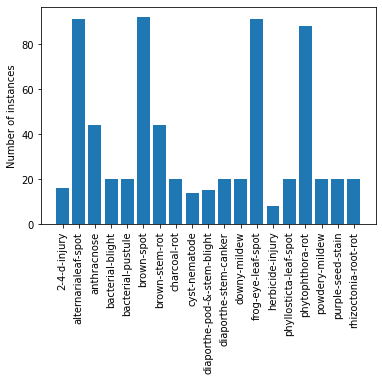

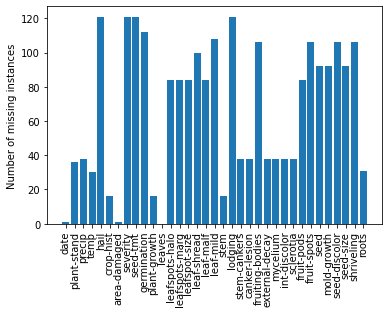

In [101]:
#Plot some information about the dataset

count_classes = {}
for c in attributes["class"]:
    df_c = df["class"] == c
    count_classes[c] = np.sum(df_c)
    
print(count_classes)

plt.figure(0)
plt.bar(count_classes.keys(), count_classes.values())
plt.ylabel("Number of instances")

plt.xticks(rotation="vertical")

plt.savefig("ex1-plots/soybeans/class_count")
plt.figure(1)

count_missing = {}
for atr in attributes.keys():
    if(atr != 'class'):
        count_missing[atr] = np.sum(df[atr] == b"?")
  
plt.bar(count_missing.keys(), count_missing.values())
plt.xticks(rotation="vertical")
plt.ylabel("Number of missing instances")

#ax = plt.figure().gca()
#ax.xaxis.get_major_locator().set_params(integer=True)

plt.savefig("ex1-plots/soybeans/missing_count")

## Preprocessing NOT DONE

In [12]:
## Turn into normalized, numerical data

# 0. Shuffle rows 
df_shuffled = df.sample(frac=1,random_state=193520285)

# 1. Transform classes to numerical ordinal data
# Encodes missing value as 0
categories_ = [
[b'?', b'april', b'may', b'june', b'july', b'august', b'september', b'october'],
[b'?', b'lt-normal', b'normal'], 
[b'?', b'lt-norm', b'norm', b'gt-norm'],
[b'?', b'lt-norm', b'norm', b'gt-norm'],
[b'?', b'no', b'yes'], #5
[b'?', b'diff-lst-year', b'same-lst-yr', b'same-lst-two-yrs', b'same-lst-sev-yrs'],
[b'?', b'scattered', b'low-areas', b'upper-areas', b'whole-field'], #not ordinal
[b'?', b'minor', b'pot-severe', b'severe'],
[b'?', b'none' , b'fungicide' , b'other'], #not ordinal
[b'?', b'90-100',b'80-89',b'lt-80'], #10
[b'?', b'norm', b'abnorm'],
[b'?', b'norm', b'abnorm'],
[b'?', b'absent', b'no-yellow-halos', b'yellow-halos'], #not ordinal
[b'?', b'dna', b'no-w-s-marg', b'w-s-marg'], #not ordinal
[b'?', b'dna', b'lt-1/8', b'gt-1/8'],
attributes['leaf-shread'],
attributes['leaf-malf'],
[b'?', b'absent', b'lower-surf', b'upper-surf'], #not ordinal
[b'?', b'norm', b'abnorm'],
[b'?', b'no', b'yes'],    #20
[b'?', b'absent',b'below-soil',b'above-soil',b'above-sec-nde'],
[b'?', b'dna',b'tan', b'brown',b'dk-brown-blk'],
[b'?', b'absent', b'present'],
[b'?', b'absent', b'watery', b'firm-and-dry'], #not ordinal    
[b'?', b'absent', b'present'],    #25
attributes['int-discolor'], #not ordinal
[b'?', b'absent', b'present'],
attributes['fruit-pods'], #not ordinal
attributes['fruit-spots'], #not ordinal
[b'?', b'norm', b'abnorm'], #30
[b'?', b'absent', b'present'],
[b'?', b'absent', b'present'],
[b'?', b'lt-norm', b'norm'],
[b'?', b'absent', b'present'],
[b'?', b'norm',b'rotted',b'galls-cysts'], #35 not ordinal
[b'diaporthe-stem-canker', b'charcoal-rot', b'rhizoctonia-root-rot', b'phytophthora-rot', b'brown-stem-rot', b'powdery-mildew', b'downy-mildew', b'brown-spot', b'bacterial-blight', b'bacterial-pustule', b'purple-seed-stain', b'anthracnose', b'phyllosticta-leaf-spot', b'alternarialeaf-spot', b'frog-eye-leaf-spot', b'diaporthe-pod-&-stem-blight', b'cyst-nematode', b'2-4-d-injury', b'herbicide-injury']
]

not_ordinal = [6, 8, 12,13, 17, 23, 25, 27,28,34]

oe = skl.preprocessing.OrdinalEncoder(categories = categories_)
oe.fit(df_shuffled)
df_ordinal =  oe.transform(df_shuffled)


# Split into training and test-set
X = df_ordinal[:,:-1]
Y = df_ordinal[:,-1:]
hX_train, hX_test, hY_train, hY_test = skl.model_selection.train_test_split(X,Y, test_size=0.2)

def imputeData(X_train, Y_train, X_test, Y_test, n=4):
    
    # Training set: Remove entry if >some value n of missing values
    x = np.delete(X_train,np.sum(X_train==0, axis=1), axis=0)
    y = np.delete(Y_train,np.sum(X_train==0, axis=1), axis=0)


    # For those with less than n missing values, impute data using median
    imputer = SimpleImputer(missing_values=0, strategy="median")
    imputer.fit(x)
    x = imputer.transform(x)
    
    # Use imputer fitted with training data to impute test data
    xt = imputer.transform(X_test)
    
    # Subtract 1 since 1 is no longer nan
    x = x-1
    xt = xt-1
    
    # One hot encode non ordinal data
    non_ordinals = x[:,not_ordinal]
    hot_encoder = skl.preprocessing.OneHotEncoder(sparse=False)
    hot_encoder.fit(non_ordinals)
    non_ordinals = hot_encoder.transform(non_ordinals)
 
    x = np.delete(x, not_ordinal, axis=1)
    x = np.concatenate((x,non_ordinals), axis = 1)
    
    non_ordinals = xt[:,not_ordinal]
    non_ordinals = hot_encoder.transform(non_ordinals)
    
    xt = np.delete(xt, not_ordinal, axis=1)
    xt = np.concatenate((xt,non_ordinals), axis = 1)

    # Fit data between 0 and 1
    scaler = skl.preprocessing.MinMaxScaler()
    scaler.fit(x)
    x = scaler.transform(x)
    
    #Return imputed x, y for training
    #Return xt as test x imputed using training data and Y_test which is not modified.
    return x,y, xt, Y_test

# Perform data impution for holdout 
hX_train, hY_train, hX_test, hY_test = imputeData(hX_train, hY_train, hX_test, hY_test)

cross_validator = skl.model_selection.StratifiedKFold(n_splits=5)


## Prepare evaluation methods

In [21]:
def evaluateModelFromDataset(model, X_train, Y_train, X_test, Y_test):
    start = time.time()
    
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    delta = (time.time()-start)/len(Y_test)*1000
    
    # zero_division is set to zero because cross-validation causes some test samples to have zero examples for some classes.
    # This means that our scores seem worse than they are. 
    report = skl.metrics.classification_report(Y_test,Y_pred, output_dict=True, zero_division=0)
    
    
    #Reports precision of phishing links, total accuracy and the time delta fitting and classifying took per test sample (ms)
    return report['weighted avg']['precision'], report['accuracy'], delta

def evaluateModel(model, do_print = True):

    #Test holdout
    holdout_rep = evaluateModelFromDataset(model, hX_train, hY_train.flatten(), hX_test, hY_test)
    
    #Test cross-evaluation
    report_precision = []
    report_accuracy  = []
    report_time = []
    for train_index, test_index in cross_validator.split(X,Y):
        X_train = X[train_index]
        Y_train = Y[train_index]
        X_test  = X[test_index]
        Y_test  = Y[test_index]
        
        X_train, Y_train,  X_test, Y_test = imputeData(X_train, Y_train, X_test, Y_test)
        
        rep = evaluateModelFromDataset(model, X_train, Y_train.flatten(), X_test, Y_test)
        report_precision.append(rep[0])
        report_accuracy.append(rep[1])
        report_time.append(rep[2])
    
    if(do_print):
        print(f"Holdout weighted average recall: {holdout_rep[0]}, accuracy: {holdout_rep[1]}")
        print(f"Cross-evaluation average recall: {np.mean(report_precision)}, std: {np.std(report_precision)}")
        print(f"Cross-evaluation average accuracy: {np.mean(report_accuracy)}, std: {np.std(report_accuracy)}")
        print(f"Holdout time: {holdout_rep[2]}, cross-evaluation mean time: {np.mean(report_time)}, std: {np.std(report_time)}")
    return [holdout_rep[0], np.mean(report_precision)], [holdout_rep[1], np.mean(report_accuracy)], [holdout_rep[2], np.mean(report_time)]

## kNN

In [ ]:
#Calculate kNN

precisions = []
accuracies = []
times = []
ks = range(2,6)
for k in ks:
    kNN_L1 = kNN(n_neighbors=k, p=1)
    kNN_L2 = kNN(n_neighbors=k, p=2)
    
    print(f"-- k={k}, L1 --")
    repL1 = evaluateModel(kNN_L1)
    
    print(f"-- k={k}, L2 --")
    repL2 = evaluateModel(kNN_L2)
    
    precisions.append(repL1[0] + repL2[0])
    accuracies.append(repL1[1] + repL2[1])
    times.append(repL1[2] + repL2[2])
    
    
print("Done!")

<Figure size 432x288 with 0 Axes>

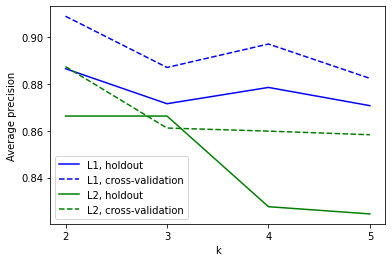

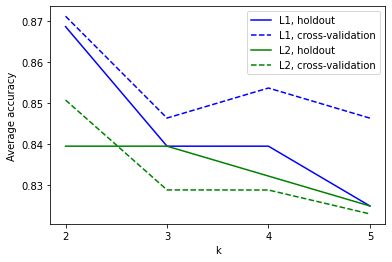

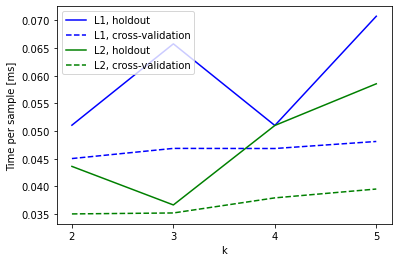

In [18]:
#Plot kNN
# plot kNN-findings

precisionsT = np.transpose(precisions)
accuraciesT = np.transpose(accuracies)
timesT = np.transpose(times)

#order: holdout L1, cross L1, holdout L2, cross L2
colorScheme = ['b-','b--','g-', 'g--']
legends = ["L1, holdout", "L1, cross-validation", "L2, holdout", "L2, cross-validation"]

plt.figure(0)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(precisionsT)):
    plt.plot(ks, precisionsT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Average precision')
plt.legend(legends, loc = "lower left")

#plt.ylim([0.9,1])

plt.savefig("ex1-plots/soybeans/kNNrecall.png")

plt.figure(1)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(accuraciesT)):
    plt.plot(ks, accuraciesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Average accuracy')
plt.legend(legends, loc = "upper right")
#plt.ylim([0.9,1])

plt.savefig("ex1-plots/soybeans/kNNaccuracy")

plt.figure(2)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(timesT)):
    plt.plot(ks, timesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Time per sample [ms]')
plt.legend(legends, loc = "upper left")

plt.savefig("ex1-plots/soybeans/kNNtime")



## LDA

In [25]:
#Calculate LDA

# default = single value decomposition
lda = LinearDiscriminantAnalysis()
evaluateModel(lda)

Holdout weighted average recall: 0.676967590724342, accuracy: 0.656934306569343
Cross-evaluation average recall: 0.7904900392453482, std: 0.05785028700218786
Cross-evaluation average accuracy: 0.7057213396307428, std: 0.01854430993802786
Holdout time: 0.2262331273433936, cross-evaluation mean time: 0.09345254605294503, std: 0.0051673846256186816


([0.676967590724342, 0.7904900392453482],
 [0.656934306569343, 0.7057213396307428],
 [0.2262331273433936, 0.09345254605294503])

In [ ]:
#Plot LDA

## Random Forest

In [26]:
#Calculate Random Forest

# calculate random forest for different number of forests/ different split measurements
num_trees = [1,2,4,6,8,10, 20, 50, 100, 200]

precisions = []
accuracies = []
times = []
for n in num_trees:
    
    print(f"-- Gini, Num trees: {n} --")
    randomForestGini = RandomForestClassifier(n_estimators = n, criterion="gini")
    repGini = evaluateModel(randomForestGini)
    
    print(f"-- Entropy, Num trees: {n} --")
    randomForestEntropy = RandomForestClassifier(n_estimators = n, criterion="entropy")
    repEntropy = evaluateModel(randomForestEntropy)
    
    precisions.append(repGini[0] + repEntropy[0])
    accuracies.append(repGini[1] + repEntropy[1])
    times.append(repGini[2] + repEntropy[2])
    
print("Done!")
    

-- Gini, Num trees: 1 --
Holdout weighted average recall: 0.7990267639902675, accuracy: 0.781021897810219
Cross-evaluation average recall: 0.6399965851520821, std: 0.12390240298754113
Cross-evaluation average accuracy: 0.6470373550880206, std: 0.08867402955275284
Holdout time: 0.021762221399014885, cross-evaluation mean time: 0.023730328892781122, std: 0.002810968188146866
-- Entropy, Num trees: 1 --
Holdout weighted average recall: 0.6631666859769049, accuracy: 0.6788321167883211
Cross-evaluation average recall: 0.7127342700703015, std: 0.05834559876677334
Cross-evaluation average accuracy: 0.7073207385143838, std: 0.06335859012245386
Holdout time: 0.021915366179751653, cross-evaluation mean time: 0.023614410782843098, std: 0.005459423167704458
-- Gini, Num trees: 2 --
Holdout weighted average recall: 0.7589676746611053, accuracy: 0.7737226277372263
Cross-evaluation average recall: 0.6828379952452521, std: 0.06707131393324939
Cross-evaluation average accuracy: 0.6646522112494633, std:

<Figure size 432x288 with 0 Axes>

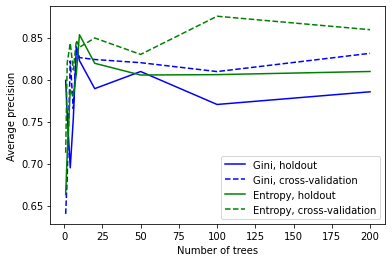

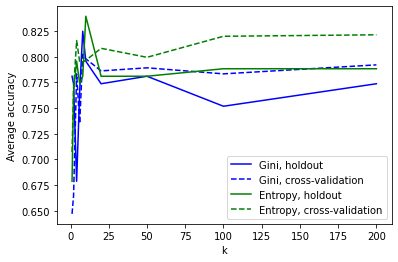

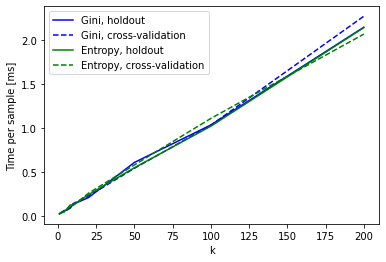

In [28]:
#Plot Random Forest

# plot random forest

# plot kNN-findings
precisionsT = np.transpose(precisions)
accuraciesT = np.transpose(accuracies)
timesT = np.transpose(times)

#order: holdout L1, cross L1, holdout L2, cross L2
colorScheme = ['b-','b--','g-', 'g--']
legends = ["Gini, holdout", "Gini, cross-validation", "Entropy, holdout", "Entropy, cross-validation"]

plt.figure(0)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(precisionsT)):
    plt.plot(num_trees, precisionsT[i],colorScheme[i]) 

plt.xlabel('Number of trees')
plt.ylabel('Average precision')
plt.legend(legends, loc = "lower right")

#plt.ylim([0.96,1])

plt.savefig("ex1-plots/soybeans/RandomForestSensitivity.png")

plt.figure(1)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(accuraciesT)):
    plt.plot(num_trees, accuraciesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Average accuracy')
plt.legend(legends, loc = "lower right")
#plt.ylim([0.96,1])

plt.savefig("ex1-plots/soybeans/RandomForestAccuracy")

plt.figure(2)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(timesT)):
    plt.plot(num_trees, timesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Time per sample [ms]')
plt.legend(legends, loc = "upper left")

plt.savefig("ex1-plots/soybeans/RandomForestTime")


